In [2]:
import detectron2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.logger import setup_logger
from pathlib import Path
from typing import List
import numpy as np
import os
import cv2
import re
import imutils
%matplotlib inline
from matplotlib import pyplot as plt
import pytesseract

from alice.config import PROCESSING_INPUT_DIR
from alice.predict import predict_masks
from alice.visualise import visualise_mask
from alice.utils import *
from collections import OrderedDict
from itertools import zip_longest
from imutils import perspective
from typing import List
from operator import attrgetter

import cv2
import numpy as np
from pathlib import Path
from typing import List
import numpy as np
import os
import cv2
import re
import imutils
import pandas as pd
import csv
%matplotlib inline
from matplotlib import pyplot as plt

from alice.east import EastTextDetection

In [3]:
from IPython.lib.deepreload import reload
%load_ext autoreload
%autoreload 2

In [4]:
# paths = [PROCESSING_INPUT_DIR / f'011245996_additional_{i}.jpeg' for i in range(1,5)]

# paths = [PROCESSING_INPUT_DIR / f'Tri434014_additional_{i}.JPG' for i in range(1,5)]

paths = [PROCESSING_INPUT_DIR / f'011250151_additional({i}).JPG' for i in range(1,5)]

In [8]:
class Quadrilateral:
    def __init__(self, vertices, is_approx=False):
        # Closest point to the bottom of the canvas
        self.closest_point = self.get_closest_point(vertices)
        
        # Vertices are assigned to a,b,c,d
        # A will be the closest point (with the maximum y value), with the points
        # ordered counter clockwise, with b being the next corner counter clockwise
        # A & C will be opposite each other; B & D opposite
        self.vertices = OrderedDict(zip(['a', 'b', 'c', 'd'], iter_list_from_value(vertices, self.closest_point)))
        
        # Loop through vertices, creating edges names a_b, b_c etc.,
        self.edges = OrderedDict([(
            f'{k1}_{k2}', LineString([
                self.vertices[k1], 
                self.vertices[k2]
            ])) for k1, k2 in pairwise(list(self.vertices.keys()))
        ])
        self.angles = self.get_corner_angles()

    @staticmethod
    def get_closest_point(vertices):
        """
        Get point with lowest y value
        """
        vertices = np.array(vertices)
        return tuple(vertices[np.argmax(vertices[:, 1])])        

    def get_corner_angles(self):
        angles = {}
        for e1, e2 in pairwise(list(self.edges.keys())):
            # The corner will be duplicated by the edge names: tl_tr, tr_br => tr
            vertice = Counter(e1.split('_') + e2.split('_')).most_common(1)[0][0]
            angles[vertice] = calculate_angle_between_lines(self.edges[e1], self.edges[e2])  
        return angles

    def is_wellformed_label_shape(self):
        """
        Validate the label shape, 4 corners & opposite angles be within 15 degrees
        """
        valid_angle = 15
        if len(self.vertices) != 4:
            return False
        oppos_corners = [('a', 'c'), ('b', 'd')]
        max_angle_diff = max([abs(self.angles[i] - self.angles[j]) for i,j in oppos_corners])  
        return max_angle_diff < valid_angle

    def visualise(self, image):
        for edge in self.edges.values():
            p = np.array(edge.coords).astype(np.int32)
            cv2.line(image, p[0], p[1], (0, 255, 0), 5)
        for point in self.vertices.values():
            pt = np.array(point).astype(np.int32)
            cv2.circle(image, pt, 5, (255,0,0), 5)
        return image

    def get_perspective_transformed(self, image):

        max_x = round(max([self.edges['a_b'].length, self.edges['c_d'].length])) - 1
        max_y = round(max([self.edges['b_c'].length, self.edges['d_a'].length])) - 1
        
        dest = np.float32([
            (0, max_x), #A
            (0, 0), #B
            (max_y, 0), #C
            (max_y, max_x) #D
        ])
        
        src = np.float32(list(self.vertices.values()))
        M = cv2.getPerspectiveTransform(src, dest)
        
        return M, cv2.warpPerspective(image,M,(max_y, max_x),flags=cv2.INTER_LINEAR)           

class Mask():
    def __init__(self, data: np.array):
        self._data = data

    @property
    def height(self):
        return self._data.shape[0]

    @property
    def width(self):
        return self._data.shape[1]  

    @property
    def y_midpoint(self):
        """
        Vertical midpoint of a mask
        """        
        return sum([min(np.where(self._data == True)[0]), max(np.where(self._data == True)[0])]) / 2 
        
    def contour(self, epsilon=5):
        contours, _ = cv2.findContours(self._data.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        # Simplify contour - otherwise approx_best_fit_ngon takes many seconds
        # Requires low epsilon < 10 otherwise approx vertices are out
        if epsilon:
            contours = cv2.approxPolyDP(contours[0], epsilon, True)        
        return contours

    def edges(self) -> np.array:
        """
        Get edges of a mask
        """
        # Diff will reduce width by 1, so prepend with extra column of 0s
        return np.diff(self._data, prepend=np.zeros(self.height)[0])  

    def edge_points(self) -> List:   
        """
        Get the edges 
        """    
        # Find the indices of True values in the mask, and return row col (points)
        return [(col, row) for row, col in np.argwhere(self.edges())]  

    def to_quadrilateral(self):
        """
        Get quadrilateral around mask
        """
        vertices = approx_best_fit_ngon(self.contour())
        quad = Quadrilateral(vertices)
        if quad.is_wellformed_label_shape():        
            return quad
        
        # TODO: Log
        # We want to get the two edges intersection at point A (closest corner)
        closest_edges = [quad.edges[e] for e in ['a_b', 'd_a']]
        vertices = approx_quadrilateral_from_closest_edges(closest_edges, self)
        approx_quad = Quadrilateral(vertices, is_approx=True)
        if approx_quad.is_wellformed_label_shape():
            return approx_quad  

        # TODO: Log 

class AngledView():

    """
    A view of the specimen 
    """

    min_mask_size = 1500
    
    def __init__(self, path: Path):
        # FIXME: Reading image twice
        self.image = cv2.imread(str(path))
        self.predictions = predict_masks(path)
        self.masks = self.masks_from_predictions(self.predictions)
        self.quads = self.masks_to_quadrilaterals()

    def masks_from_predictions(self, predictions):
        masks = self.predictions.get('instances').to("cpu").pred_masks.numpy()
        masks = self.filter_small_masks(masks)
        masks = self.remove_overlaps(masks)
        masks = [Mask(m) for m in masks]
        # Sort by mask y midpoint
        masks.sort(key = attrgetter('y_midpoint'))
        return masks

    def masks_to_quadrilaterals(self):
        return [mask.to_quadrilateral() for mask in self.masks]
        
    def filter_small_masks(self, masks: np.array):
        return [m for m in masks if np.count_nonzero(m) > self.min_mask_size]

    def remove_overlaps(self, masks: np.array):
        # FIXME: Doesn't work in Ariana's code
        return masks

    def __len__(self):
        return len(self.masks)

class Specimen():
    def __init__(self, paths: List[Path]):
        self.views = [AngledView(p) for p in paths]
        # TODO: Get the mean of the mask count, and drop any views not corresponding to mean
        # TODO: Log error

    def __iter__(self):
        for view in self.views:
            yield view

    def __len__(self):
        return len(self.views)

    def __getitem__(self, i):
        return self.views[i]

specimen = Specimen(paths)

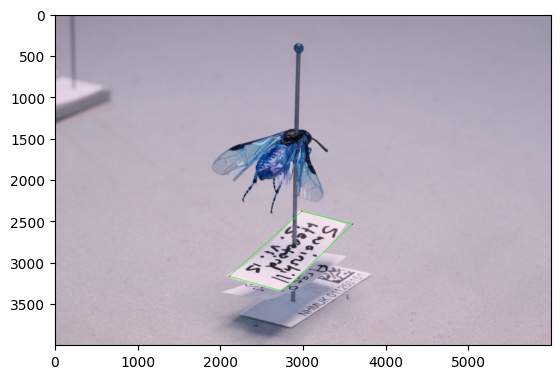

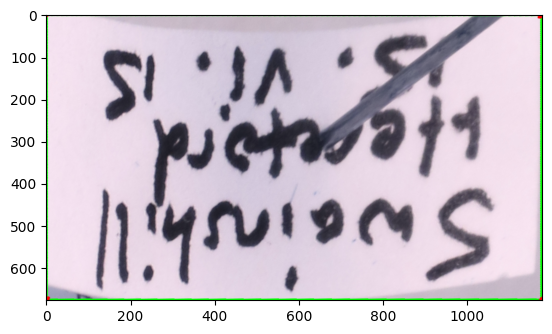

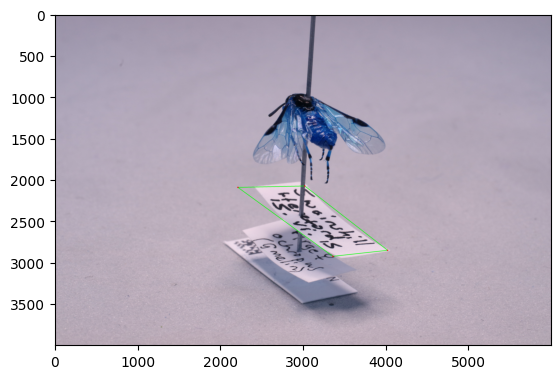

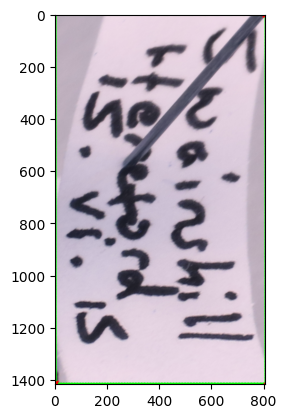

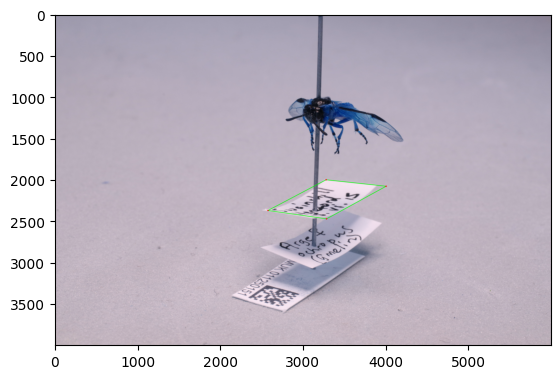

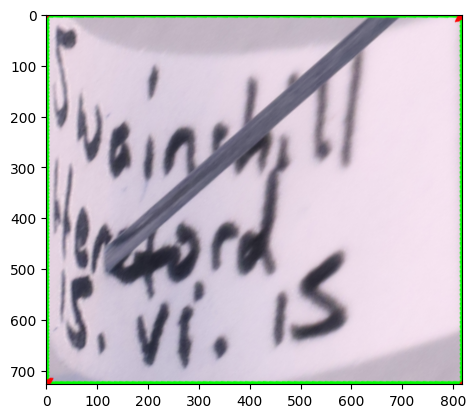

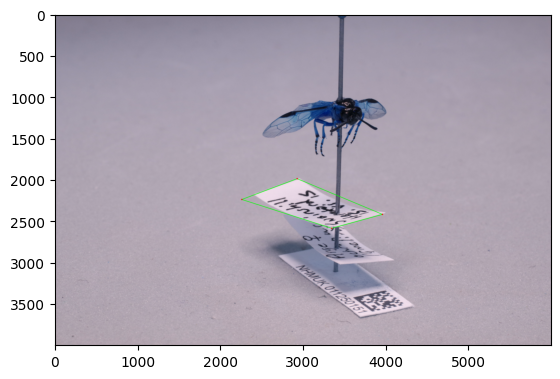

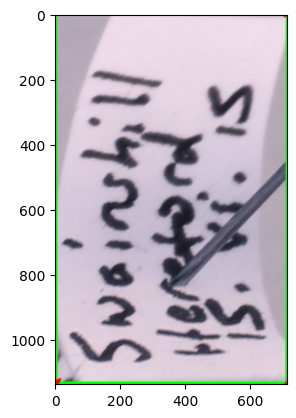

In [11]:
for view in specimen:
    for quad in view.quads:
        vis = quad.visualise(view.image)
        plt.imshow(vis), plt.show()

        _, v = quad.get_perspective_transformed(view.image)
        plt.imshow(v), plt.show()
        break



In [7]:
# TODO: Check all views have the same number of images

num_labels_per_view = np.array([len(view) for view in specimen])
is_equal_num_per_view = len(np.unique(num_labels_per_view)) == 1

label_index = 1

short_side = []
long_side = []
for i, view in enumerate(specimen):
    quad = view.quads[label_index]

    edge_lens = sorted([
        round(max([quad.edges['a_b'].length, quad.edges['c_d'].length])) - 1,
        round(max([quad.edges['b_c'].length, quad.edges['d_a'].length])) - 1
    ])

    short_side.append(edge_lens[0])
    long_side.append(edge_lens[1])

norm_dims = [max(long_side), max(short_side)]    

images = []

for i, view in enumerate(specimen):

#     # If we don't have the same  number of labels per view, drop the view not matching the median
#     if not is_equal_num_per_view and len(view) != np.median(num_labels_per_view):
#         print("SKIPPING - not same num")
#         continue

    
    image = deepcopy(view.image)
    quad = view.quads[label_index]

    max_x = round(max([quad.edges['a_b'].length, quad.edges['c_d'].length])) - 1
    max_y = round(max([quad.edges['b_c'].length, quad.edges['d_a'].length])) - 1

    if max_x > max_y:
        max_x = max(norm_dims)
        max_y = min(norm_dims)
    else:
        max_x = min(norm_dims)
        max_y = max(norm_dims)    

    dest = np.float32([
        (0, max_x), #A
        (0, 0), #B
        (max_y, 0), #C
        (max_y, max_x) #D
    ])
        
    src = np.float32(list(quad.vertices.values()))
    M = cv2.getPerspectiveTransform(src, dest)
    
    transformed = cv2.warpPerspective(image,M,(max_y, max_x),flags=cv2.INTER_LINEAR) 

    # Longest edge should be the bottom
    h, w = transformed.shape[:2]
    if h > w:
        rotate_angle = -90
    
    # Align all the same way - rotate 90 degrees x position
    transformed = imutils.rotate_bound(transformed, rotate_angle + (90 * i))

    # # img = quad.visualise(img)
    plt.imshow(transformed)
    plt.show() 

    images.append(transformed)
    

    


NameError: name 'rotate_angle' is not defined

In [8]:
for i, img in enumerate(images):
    # print(img.shape)
    cv2.imwrite(f'norm-image{i}.jpg', img)
    

In [ ]:
def dewarp_text(image, n_splines = 5):
    # Grayscale it, Otsu's threshold
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    
    # Dilation & Erosion to fill holes inside the letters
    kernel = np.ones((3, 3), np.uint8)
    thresh = cv2.erode(thresh, kernel, iterations=1)
    thresh = cv2.dilate(thresh, kernel, iterations=1)  

    # scatter = []

    # # Write in csv file
    # for x in range(thresh.shape[0]):
    #     for y in range(thresh.shape[1]):
    #         # Search for black pixels
    #         if (thresh[x][y] <= 128):
    #             scatter.append({
    #                 'Y': y,
    #                 'X': thresh.shape[0] - x
    #             })

    # df = pd.DataFrame(scatter)


    # Open csv file
    f = open('./scatterplot_records.csv', 'w')
    
    # Create the csv writer
    writer = csv.writer(f)
    writer.writerow(['X', 'Y'])
    
    # Write in csv file
    for x in range(thresh.shape[0]):
        for y in range(thresh.shape[1]):
          # Search for black pixels
          if (thresh[x][y] <= 128):
            #writer.writerow([y, x])                        # reverse/mirrored scatter-plot image
            writer.writerow([y, thresh.shape[0] - x])       # normal scatter-plot image
    
    # Close csv file
    f.close()
    
    # Read CSV file and extract info
    df = pd.read_csv('./scatterplot_records.csv', sep = ",")
    
    # Delete csv file
    os.remove('./scatterplot_records.csv')
    
    # Build GAM & define its parameters
    predictors = ['X']
    outcome = ['Y']
    X = df[predictors].values
    y = df[outcome]
    gam = LinearGAM(n_splines = n_splines)
    gam.gridsearch(X, y)
    
    # Create the offset necessary to un-curve the text
    y_hat = gam.predict(np.linspace(0, thresh.shape[1], num = thresh.shape[1]))
  
    # # Plot the image with text curve overlay
    # plt.imshow(image)
    # plt.plot(np.linspace(0, thresh.shape[1], num=thresh.shape[1]), (thresh.shape[0] - y_hat), color='red')
    # plt.show()

    # Roll each column to align the text
    for i in range(image.shape[1]):
        image[:, i, 0] = np.roll(image[:, i, 0], round(y_hat[i] - thresh.shape[0]/2))
        image[:, i, 1] = np.roll(image[:, i, 1], round(y_hat[i] - thresh.shape[0]/2))
        image[:, i, 2] = np.roll(image[:, i, 2], round(y_hat[i] - thresh.shape[0]/2))

    return image



# dewarped = dewarp_text(images[0].copy())

dewarped = [dewarp_text(image.copy()) for image in images]

# for image in images:
#     dewarped = dewarp_text(image.copy())
#     plt.imshow(image)
#     plt.show() 
#     plt.imshow(dewarped)
#     plt.show()     


In [ ]:
def sift_detector(image1, image2):
    # Initiate SIFT detector
    sift = cv2.SIFT_create(10000)
    
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)
    
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    
    matches = flann.knnMatch(des1,des2,k=2)
    
    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)

    return kp1, kp2, good          

def beblid(img1, img2):

    detector = cv2.ORB_create(10000)
    kpts1 = detector.detect(img1, None)
    kpts2 = detector.detect(img2, None)
    
    # descriptor = cv.ORB_create()
    descriptor = cv2.xfeatures2d.BEBLID_create(0.75)
    kpts1, desc1 = descriptor.compute(img1, kpts1)
    kpts2, desc2 = descriptor.compute(img2, kpts2)    

    matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_BRUTEFORCE_HAMMING)
    matches = matcher.knnMatch(desc1, desc2, 2)

    # FLANN_INDEX_KDTREE = 0
    # index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    # search_params = dict(checks = 50)
    
    # flann = cv2.FlannBasedMatcher(index_params, search_params)
    
    # matches = flann.knnMatch(desc1,desc2,k=2)
    
    good = []
    for m,n in matches:
        if m.distance < 0.8*n.distance:
            good.append(m)

    return kpts1, kpts2, good       
    

image1 = images[0].copy()
image2 = images[2].copy()

def threshold_image(image):

    cutoff_val = 200 # everything above this is set to the cutoff val
    set_color = 255 
    ret,thresh_img = cv2.threshold(image,cutoff_val,255,cv2.THRESH_TRUNC)
    window_size = 11
    thresh_img = cv2.cvtColor(thresh_img, cv2.COLOR_BGR2GRAY)
    return cv2.adaptiveThreshold(thresh_img,set_color,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,window_size,2)

img1 = threshold_image(image1)
img2 = threshold_image(image2)

kp1, kp2, good = beblid(img1, img2)

src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
matchesMask = mask.ravel().tolist()

h,w = img1.shape
pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
dst = cv2.perspectiveTransform(pts,M)

# transformed_img = cv2.warpPerspective(image1, homography, (width, height))

transformed_img = cv2.warpPerspective(image1, M, (w, h))


# img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

# print(good)

draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)

plt.figure(figsize = (50,20))
plt.imshow(transformed_img)
plt.show()

plt.figure(figsize = (50,20))
plt.imshow(image2)
plt.show()

# Create a mask for the overlay
# overlay_mask = np.ones_like(overlay_image_resized)

# Blend the images using the mask
blended_image = cv2.addWeighted(image2, 0.5, transformed_img, 0.5, 0)




plt.figure(figsize = (50,20))
plt.imshow(blended_image)
plt.show()


img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)



plt.figure(figsize = (50,20))
plt.imshow(img3)
plt.show()